# Black-Scholes Local Linear
### Sam Porritt

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph

In [2]:
def CheckAccuracy(y,y_hat):
    
    stats = dict()
    stats['diff'] = y - y_hat
    stats['mse'] = (stats['diff']**2).mean()
    print ("Mean Squared Error:      ", stats['mse'])
    stats['rmse'] = np.sqrt(stats['mse'])
    print ("Root Mean Squared Error: ", stats['rmse'])
    stats['mae'] = (np.abs(stats['diff'])).mean()
    print ("Mean Absolute Error:     ", stats['mae'])
    stats['mpe'] = np.sqrt(stats['mse'])/y.mean()
    print ("Mean Percent Error:      ", stats['mpe'])
    
    plt.figure(figsize=(10,7))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20)
    plt.ylabel('Predicted Price',fontsize=20) 
    plt.show()
    
    plt.figure(figsize=(10,7))
    plt.hist(stats['diff'], bins=200,edgecolor='black',color='blue')
    plt.xlabel('Diff',fontsize=20)
    plt.ylabel('Density',fontsize=20)
    plt.show()
    
    return stats

In [3]:
class LocalLin():
    
    def __init__(self, X, y, k):
        self.X_values = X
        self.y_values = y
        self.neighbours_graph = kneighbors_graph(X, k)

    def predict(self, x_index):
        x0 = self.X_values[x_index]
        x_neighbours_indices = self.neighbours_graph.getrow(x_index).nonzero()[1]
        x = np.array([self.X_values[i] for i in x_neighbours_indices])
        y = np.array([self.y_values[i] for i in x_neighbours_indices])
        return x0.dot(np.linalg.inv((x.transpose()).dot(x)).dot((x.transpose()).dot(y)))

In [4]:
df = pd.read_csv('training.csv').drop(columns=['Unnamed: 0'])
new_df = pd.DataFrame()
new_df['S'] = df['Stock Price'] / df['Strike Price']
new_df['C'] = df['Call Price'] / df['Strike Price']
new_df['rT'] = df['Maturity'] * df['Risk-free']
new_df['qT'] = df['Maturity'] * df['Dividends']
new_df['sigmaRootT'] = df['Volatility'] * np.sqrt(df['Maturity'])
# add all 1s feature so the linear regression formula applies
new_df['1'] = new_df['S']/new_df['S']
X, y = new_df.drop(columns=["C"]).values, new_df["C"].values

In [5]:
localLin = LocalLin(X, y, k=80)

Mean Squared Error:       3.553853879999424e-08
Root Mean Squared Error:  0.00018851668042906504
Mean Absolute Error:      0.0001267921097043385
Mean Percent Error:       0.0006961256098616911


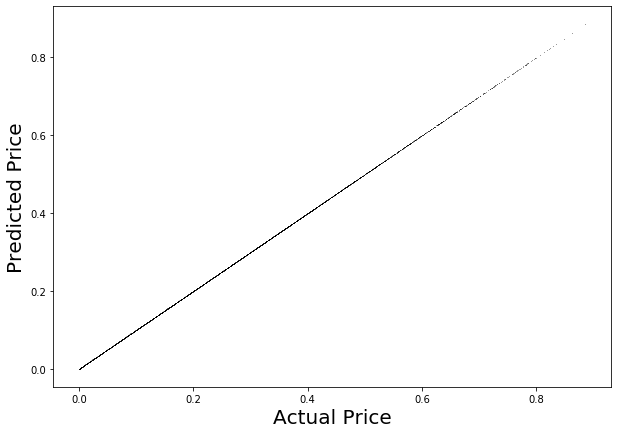

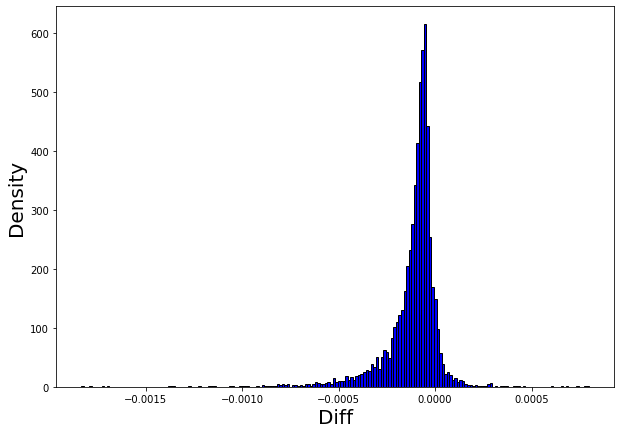

{'diff': array([ 2.17412443e-07, -5.96492317e-05, -5.93028124e-05, ...,
        -4.30629217e-05, -1.16308141e-04, -2.08935369e-04]),
 'mse': 3.553853879999424e-08,
 'rmse': 0.00018851668042906504,
 'mae': 0.0001267921097043385,
 'mpe': 0.0006961256098616911}

In [6]:
num_predictions = 6000
predictions = np.array([max(0, localLin.predict(i)) for i in range(num_predictions)])
CheckAccuracy(np.array(y[:num_predictions]), predictions)